In [67]:
from pathlib import Path

import gin
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from src.game import Game, CircleL1, CircleL2
from src.train import train

In [151]:
def plot(logdir, savedir=None, name='error', last_epochs=10, show=True):
    if savedir:
        savepath = Path(savedir)
        savepath.mkdir(exist_ok=True)
        
    logpath = Path(logdir)    

    config_file = next(logpath.glob('**/*.gin'))
    print(f'config file {config_file}')
    gin.parse_config_file(config_file, skip_unknown=True)
    
    bias = gin.config.query_parameter('Game.bias')
    num_points = gin.config.query_parameter('Game.num_points')
    num_epochs = gin.config.query_parameter('train.num_epochs')
    print(f'num epochs {num_epochs}')
    test_loss = CircleL1(num_points)
    
    run_logs = []
    for path in logpath.glob('**/*.json'):
        print(f'plotting from {path}')
        with open(path, 'r') as logfile:
            try:
                new_log = pd.read_json(logfile)
            except:
                print(f'JSON error in log at {path}')
            else:
                run_logs.append(new_log)

    logs = pd.concat(run_logs, ignore_index=True)
    sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
    recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])
    
    if show:
        metric = "test_l1_error" if "test_l1_error" in sender else "test_error"

        # Rewards
        sns.lineplot(data=sender, x="epoch", y=sender[metric]*10, label="sender")
        sns.lineplot(data=recver, x="epoch", y=recver[metric]*10, label="receiver")

        # Baselines
        nocomm_diff = torch.tensor(36 / 4)
        nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
        fair_error = test_loss(torch.tensor(0.), bias/2)*10
        plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
        plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))

        plt.ylabel(r'Test $L_1$ loss')

        if savedir:
            plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')
            
        print("here")
        plt.show()
        plt.clf()

    error_sum = pd.DataFrame(sender['test_l1_error'] + recver['test_l1_error']).join(logs['epoch'])
    error_last = error_sum[error_sum['epoch'] >= num_epochs - last_epochs]
    return [error_last[i*last_epochs:(i+1)*last_epochs]['test_l1_error'].mean() for i in range(5)] 

    
def plot_hyperparam_results(results_dir, label=None, savepath=None, last_epochs=10, show=True):
    results_path = Path(results_dir)
    results = pd.read_csv(results_path / 'results.csv')
    
#     sns.lineplot(data=results, x=results['bias']*10, y=results['l1']*10, label=label)
#     plt.plot(results['bias']*10, results['bias']*10, label=r'optimal $L_1$ loss', color="grey", dashes=(2,2,2,2))

    
#     plt.axhline(torch.tensor(2 *(9**2)), label='no communication', color="black", dashes=(2,2,2,2))
#     sns.lineplot(data=results, x=results['bias'], y=results['error'], label=label)
# #     plt.plot(results['bias']*10, results['bias']*10, label=r'optimal $L_1$ loss', color="grey", dashes=(2,2,2,2))
#     plt.ylabel(r'Test $L_{2s}$ + $L_{2r}$')
#     plt.legend()
#     if savepath is not None:
#         savepath.mkdir(exist_ok=True)
#         plt.savefig(savepath / f'{results_path.name}-all.png',  bbox_inches='tight')
#     plt.show()
#     plt.clf()
    df = pd.DataFrame()
    df = df.append([results]*5, ignore_index=True)   
    seed_scores = []
    for bias, score, run_id, l1 in results.sort_values('bias').itertuples(index=False):
        print(f'bias {bias} run_id {run_id} score {score} l1 {l1}')
        print(f'len seed scores {len(seed_scores)}')
        try:
            logdir = list(results_path.glob(f'*{bias}_{run_id}*'))[0]
            seed_scores.extend(plot(logdir, savepath, f'{results_path.name}-bias{bias}', last_epochs=last_epochs, show=show))            
        except Exception as e:
            print(f'logdir {logdir} not found for bias {bias}')
            print(f'Exception {e}')
#         plt.title(f'Bias {bias}')
    

    df.sort_values('bias', inplace=True)
    df.insert(2, 'seed_score', seed_scores)
    
    if show:
        plt.axhline(torch.tensor(360 / 2), label='no communication', color="black", dashes=(2,2,2,2))
        
    sns.lineplot(data=df, x=df['bias']*10, y=df['seed_score']*10, label=label)
    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.legend()
    if savepath is not None:
        savepath.mkdir(exist_ok=True)
        plt.savefig(savepath / f'{results_path.name}-all.png',  bbox_inches='tight')
    
    if show:
        plt.show()
        plt.clf()
    
    return df

bias 0 run_id a447e108adc389d435e27fe27d62e634 score 6.462780685424804 l1 2.72906810760498
len seed scores 0
config file ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/2/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/0/logs.json
bias 3 run_id f8f28088ab3c262928d00951fc9da6fe score 30.57552537918091 l1 6.2944153738021855
len seed scores 5
config file ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6fe/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6f

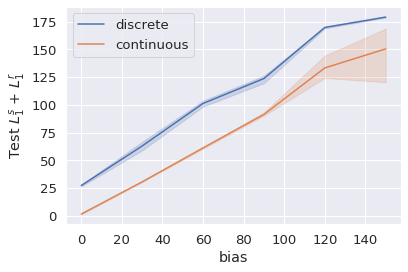

In [149]:

# basic_path = Path('../results/cat-deter-grounded')
# results = pd.read_csv(basic_path / 'results.csv')
# sns.lineplot(data=results, x='bias', y='l1', label='gauss-deter-grounded')

# lola_path = Path('../results/iclr/cat-deter')
# results = pd.read_csv(lola_path / 'results.csv')
# results['bias'] = results['bias'] * 10
# results['l1'] = results['l1'] * 10
# sns.lineplot(data=results, x='bias', y='l1', label='3 layer')

# results['optimal'] = results['bias'] + 36 / (4 * 256)
# sns.lineplot(data=results, x='bias', y='optimal', label='Optimal')

# logpath = '../results/marg-deter'
resultspath = Path('../results/cat-deter')
results2path = Path('../results/gauss-deter-3')
# lolapath = Path('../results/senderlola1-recverlola1-extended')
# lola2path = Path('../results/senderlola2-recverlola2-extended')


with sns.plotting_context('paper'):
    sns.set(font_scale=1.2)

#     plt.title(f'1 Layer')
    plot_hyperparam_results(resultspath, 'discrete', resultspath / 'plots', last_epochs=10, show=False)
    plot_hyperparam_results(results2path, 'continuous', results2path / 'plots', last_epochs=10, show=False)

#     plot_hyperparam_results(lolapath, 'LOLA', resultspath / 'plots', last_epochs=30, show=False)
#     plot_hyperparam_results(lola2path, 'LOLA2', resultspath / 'plots', show=False)



In [126]:
logdir = Path('../results/senderlola1-recverlola1-extended/senderlola1-recverlola1-bias0_81ac13d18feacf191f6046d5c1ec1300')

plot(logdir, None, None, last_epochs=20, show=True)

config file ../results/senderlola1-recverlola1-extended/senderlola1-recverlola1-bias0_81ac13d18feacf191f6046d5c1ec1300/3/config.gin
num epochs 50
plotting from ../results/senderlola1-recverlola1-extended/senderlola1-recverlola1-bias0_81ac13d18feacf191f6046d5c1ec1300/3/logs.json
plotting from ../results/senderlola1-recverlola1-extended/senderlola1-recverlola1-bias0_81ac13d18feacf191f6046d5c1ec1300/4/logs.json
plotting from ../results/senderlola1-recverlola1-extended/senderlola1-recverlola1-bias0_81ac13d18feacf191f6046d5c1ec1300/2/logs.json
plotting from ../results/senderlola1-recverlola1-extended/senderlola1-recverlola1-bias0_81ac13d18feacf191f6046d5c1ec1300/1/logs.json


ValueError: Expected object or value

bias 0 run_id a447e108adc389d435e27fe27d62e634 score 6.462780685424804 l1 2.72906810760498
len seed scores 0
config file ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/2/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/0/logs.json
here


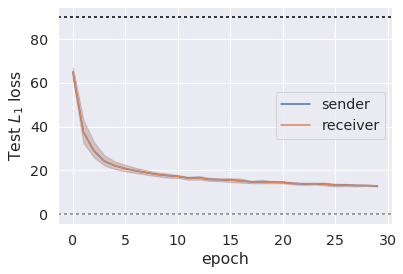

bias 3 run_id f8f28088ab3c262928d00951fc9da6fe score 30.57552537918091 l1 6.2944153738021855
len seed scores 5
config file ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6fe/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6fe/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6fe/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6fe/2/logs.json
plotting from ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6fe/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6fe/0/logs.json
here


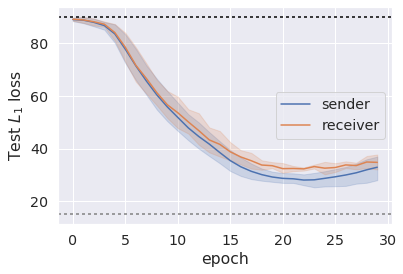

bias 6 run_id b5d709fedbf1f19fee99238b15966f80 score 78.1691774749756 l1 10.126355223655699
len seed scores 10
config file ../results/cat-deter/cat-deter-bias6_b5d709fedbf1f19fee99238b15966f80/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias6_b5d709fedbf1f19fee99238b15966f80/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias6_b5d709fedbf1f19fee99238b15966f80/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias6_b5d709fedbf1f19fee99238b15966f80/2/logs.json
plotting from ../results/cat-deter/cat-deter-bias6_b5d709fedbf1f19fee99238b15966f80/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias6_b5d709fedbf1f19fee99238b15966f80/0/logs.json
here


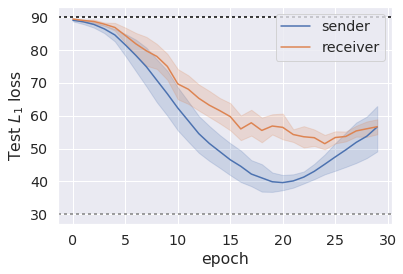

bias 9 run_id 668657b27a97dab6912ceeb5c1bd7ac4 score 114.65361896514895 l1 12.371396279335025
len seed scores 15
config file ../results/cat-deter/cat-deter-bias9_668657b27a97dab6912ceeb5c1bd7ac4/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias9_668657b27a97dab6912ceeb5c1bd7ac4/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias9_668657b27a97dab6912ceeb5c1bd7ac4/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias9_668657b27a97dab6912ceeb5c1bd7ac4/2/logs.json
plotting from ../results/cat-deter/cat-deter-bias9_668657b27a97dab6912ceeb5c1bd7ac4/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias9_668657b27a97dab6912ceeb5c1bd7ac4/0/logs.json
here


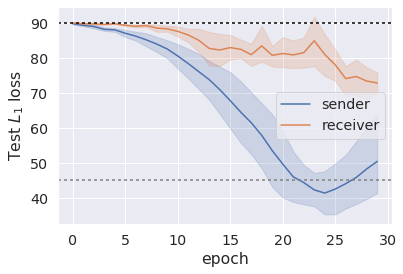

bias 12 run_id 715300018042f36cfc95844a016e2a25 score 197.8775018310547 l1 16.974620742797853
len seed scores 20
config file ../results/cat-deter/cat-deter-bias12_715300018042f36cfc95844a016e2a25/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias12_715300018042f36cfc95844a016e2a25/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias12_715300018042f36cfc95844a016e2a25/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias12_715300018042f36cfc95844a016e2a25/2/logs.json
plotting from ../results/cat-deter/cat-deter-bias12_715300018042f36cfc95844a016e2a25/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias12_715300018042f36cfc95844a016e2a25/0/logs.json
here


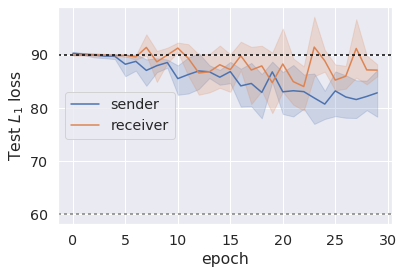

bias 15 run_id 183a325a03b5d1ff889ff654a76cb4e9 score 212.96006423950195 l1 17.910043258666988
len seed scores 25
config file ../results/cat-deter/cat-deter-bias15_183a325a03b5d1ff889ff654a76cb4e9/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias15_183a325a03b5d1ff889ff654a76cb4e9/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias15_183a325a03b5d1ff889ff654a76cb4e9/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias15_183a325a03b5d1ff889ff654a76cb4e9/2/logs.json
plotting from ../results/cat-deter/cat-deter-bias15_183a325a03b5d1ff889ff654a76cb4e9/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias15_183a325a03b5d1ff889ff654a76cb4e9/0/logs.json
here


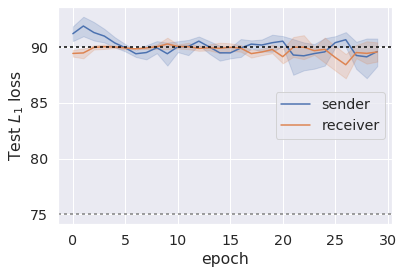

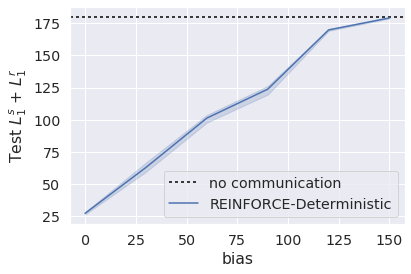

<Figure size 432x288 with 0 Axes>

In [152]:
# ## REINFORCE - DETERMINISTIC L1
# resultspath = Path('../results/cat-deter-l1')
# with sns.plotting_context('paper'):
#     sns.set(font_scale=1.3)

# #     plt.title(f'LOLA-{i}')
# #     plot(logpath)
#     plot_hyperparam_results(resultspath, 'REINFORCE-Deterministic', resultspath / 'plots')

## REINFORCE - DETERMINISTIC L2
resultspath = Path('../results/cat-deter')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

#     plt.title(f'LOLA-{i}')
#     plot(logpath)
    plot_hyperparam_results(resultspath, 'REINFORCE-Deterministic', resultspath / 'plots')

    

bias 0 run_id f04f33df38cd4ed3e69482dd85907048 score 0.08580408535897648 l1 1.3753189039230338
config file ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/2/logs.json
bias 3 run_id b9943073309d9e9fadd5957e148c0c46 score 3.9888681745529175 l1 9.791334295272828
config file ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/logs.json
plotting from ../results/cat-deter/cat-deter-b

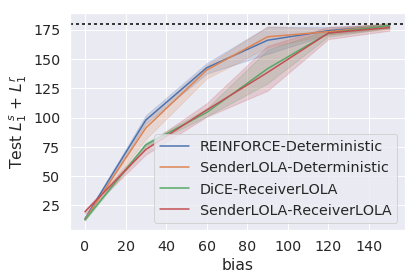

In [418]:
## LOLA 1 GRAPH
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    
    logpath = Path('../results/cat-deter')
    label='REINFORCE-Deterministic'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    logpath = Path('../results/senderlola1-deter')
    label='SenderLOLA-Deterministic'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
    logpath = Path('../results/senderlola0-recverlola1')
    label='DiCE-ReceiverLOLA'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)


    logpath = Path('../results/senderlola1-recverlola1')
    label='SenderLOLA-ReceiverLOLA'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    plt.axhline(torch.tensor(360 / 2), label='no communication', color="black", dashes=(2,2,2,2))

    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.savefig(f'../results/lola1-all.png',  bbox_inches='tight')


bias 0 run_id 1364d13198b3d4eb1264cab01dbf2705 score 2.6603458952903742 l1 1.9628803229331964
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/0/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/0/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/2/logs.json
bias 3 run_id 24bc831a5e440cfbc02da489d2f155e4 score 38.88937200546265 l1 7.273522143363952
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-

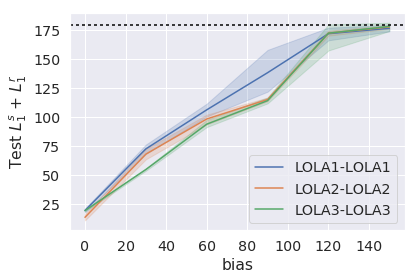

In [419]:
## LOLA 1,2,3 L2 GRAPH
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    
#     logpath = Path('../results/cat-deter')
#     label='REINFORCE-Deterministic'
#     results = pd.read_csv(logpath / 'results.csv')
#     sns.lineplot(data=results, x=results['bias']*10, y=results['l1']*10, label=label)

    logpath = Path('../results/senderlola1-recverlola1')
    label='LOLA1-LOLA1'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
    logpath = Path('../results/senderlola2-recverlola2')
    label='LOLA2-LOLA2'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
    logpath = Path('../results/senderlola3-recverlola3')
    label='LOLA3-LOLA3'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
    plt.axhline(torch.tensor(360 / 2), color="black", dashes=(2,2,2,2))
    plt.legend()

    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.savefig(f'../results/lola123-all.png',  bbox_inches='tight')

bias 0 run_id 5c2c4aab49edb9fb9e61cfb9a2220a5b score 1.2162181532382956 l1 1.2743104827404017
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/2/logs.json


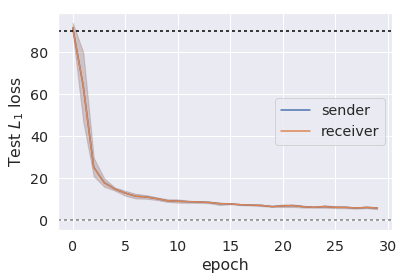

bias 3 run_id 942cd8a3e04b7edc541ea5dffbb05f74 score 45.8254821395874 l1 7.677191071510316
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/2/logs.json


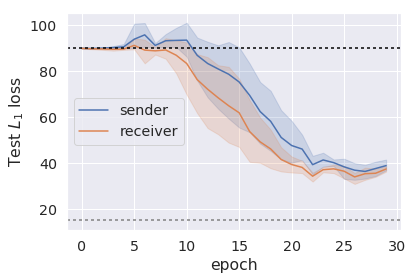

bias 6 run_id 31e13f27718fb464b556f41b83de2b3e score 82.56045627593994 l1 10.435690326690674
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/2/logs.json


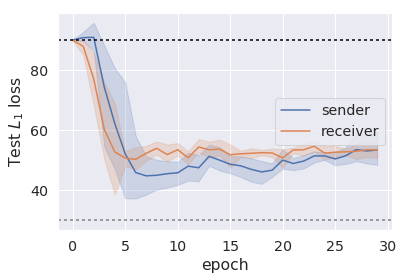

bias 9 run_id b652474dd4a0c7d1c5357d2cdfc177a0 score 146.7813547897339 l1 14.167479429244995
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/2/logs.json


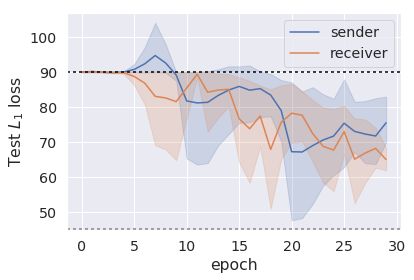

bias 12 run_id 0378eec008a621b553c96330585b1090 score 201.1128600311279 l1 17.19542788505554
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/2/logs.json


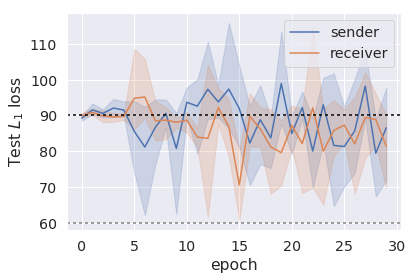

bias 15 run_id c405e967c4e4e63c684381c74e907712 score 212.0104367828369 l1 17.851364488601686
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/2/logs.json


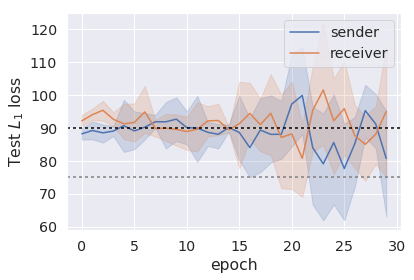

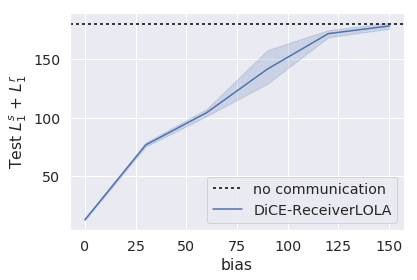

<Figure size 432x288 with 0 Axes>

In [420]:
## DiCE - ReceiverLOLA 1
resultspath = Path('../results/senderlola0-recverlola1')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'DiCE-ReceiverLOLA', resultspath / 'plots')

bias 0 run_id a447e108adc389d435e27fe27d62e634 score 6.462780685424804 l1 2.72906810760498
len seed scores 0
config file ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/2/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_a447e108adc389d435e27fe27d62e634/0/logs.json
bias 3 run_id f8f28088ab3c262928d00951fc9da6fe score 30.57552537918091 l1 6.2944153738021855
len seed scores 5
config file ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6fe/3/config.gin
num epochs 30
plotting from ../results/cat-deter/cat-deter-bias3_f8f28088ab3c262928d00951fc9da6f

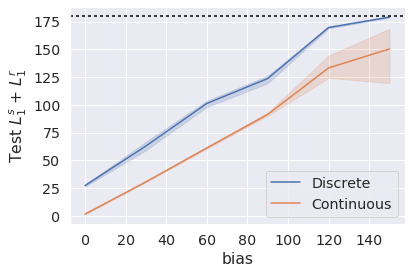

In [153]:
## Continuous GRAPH
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    
    logpath = Path('../results/cat-deter')
    label='Discrete'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)
    
    logpath = Path('../results/gauss-deter-3')
    label='Continuous'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
#     logpath = Path('../results/noise-deter')
#     label='Grounded'
#     plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
#     logpath = Path('../results/noiselola1-recverlola1')
#     label='Grounded-LOLA1'
#     plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)


    plt.axhline(torch.tensor(360 / 2), color="black", dashes=(2,2,2,2))
    
#     plt.legend(loc='lower right', n_cols=2)
    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.savefig(f'../results/discrete-v-continuous.png',  bbox_inches='tight')

bias 0 run_id 679821d430aef76891fb84566fca1acf score 0.03154523134929956 l1 0.1578468009084454
len seed scores 0
config file ../results/gauss-deter-3/gauss-deter-3-bias0_679821d430aef76891fb84566fca1acf/3/config.gin
num epochs 30
plotting from ../results/gauss-deter-3/gauss-deter-3-bias0_679821d430aef76891fb84566fca1acf/3/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias0_679821d430aef76891fb84566fca1acf/4/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias0_679821d430aef76891fb84566fca1acf/2/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias0_679821d430aef76891fb84566fca1acf/1/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias0_679821d430aef76891fb84566fca1acf/0/logs.json
here


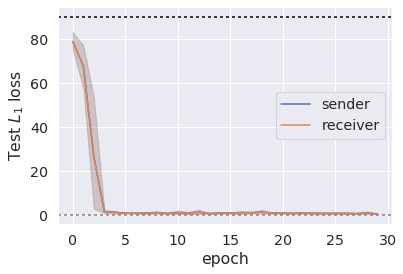

bias 3 run_id d803cda9a355a1a726a52504cc98f0c8 score 8.871101568341254 l1 3.060370800681411
len seed scores 5
config file ../results/gauss-deter-3/gauss-deter-3-bias3_d803cda9a355a1a726a52504cc98f0c8/3/config.gin
num epochs 30
plotting from ../results/gauss-deter-3/gauss-deter-3-bias3_d803cda9a355a1a726a52504cc98f0c8/3/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias3_d803cda9a355a1a726a52504cc98f0c8/4/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias3_d803cda9a355a1a726a52504cc98f0c8/2/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias3_d803cda9a355a1a726a52504cc98f0c8/1/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias3_d803cda9a355a1a726a52504cc98f0c8/0/logs.json
here


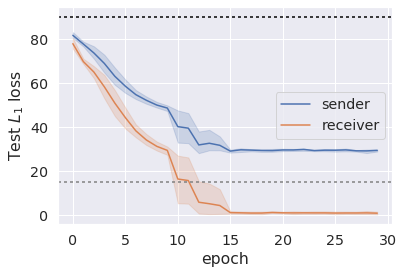

bias 6 run_id b38fcf35dea6f4a5b4d10b6c7e92f077 score 35.78332414109725 l1 6.116579580567777
len seed scores 10
config file ../results/gauss-deter-3/gauss-deter-3-bias6_b38fcf35dea6f4a5b4d10b6c7e92f077/3/config.gin
num epochs 30
plotting from ../results/gauss-deter-3/gauss-deter-3-bias6_b38fcf35dea6f4a5b4d10b6c7e92f077/3/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias6_b38fcf35dea6f4a5b4d10b6c7e92f077/4/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias6_b38fcf35dea6f4a5b4d10b6c7e92f077/2/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias6_b38fcf35dea6f4a5b4d10b6c7e92f077/1/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias6_b38fcf35dea6f4a5b4d10b6c7e92f077/0/logs.json
here


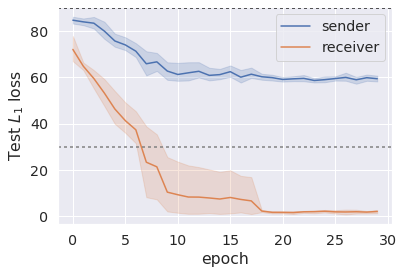

bias 9 run_id a465ccb48b8d01d59453cc8f9afa9197 score 80.26489805269054 l1 9.138226482942702
len seed scores 15
config file ../results/gauss-deter-3/gauss-deter-3-bias9_a465ccb48b8d01d59453cc8f9afa9197/3/config.gin
num epochs 30
plotting from ../results/gauss-deter-3/gauss-deter-3-bias9_a465ccb48b8d01d59453cc8f9afa9197/3/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias9_a465ccb48b8d01d59453cc8f9afa9197/4/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias9_a465ccb48b8d01d59453cc8f9afa9197/2/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias9_a465ccb48b8d01d59453cc8f9afa9197/1/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias9_a465ccb48b8d01d59453cc8f9afa9197/0/logs.json
here


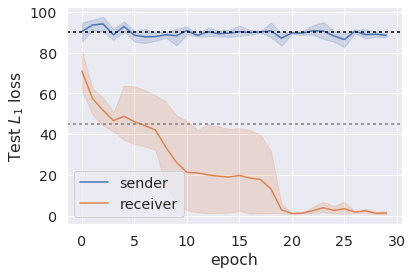

bias 12 run_id 4ec923be703dd00c8fdd53ce6bf7d2d1 score 159.05625782342628 l1 13.327244703881442
len seed scores 20
config file ../results/gauss-deter-3/gauss-deter-3-bias12_4ec923be703dd00c8fdd53ce6bf7d2d1/3/config.gin
num epochs 30
plotting from ../results/gauss-deter-3/gauss-deter-3-bias12_4ec923be703dd00c8fdd53ce6bf7d2d1/3/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias12_4ec923be703dd00c8fdd53ce6bf7d2d1/4/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias12_4ec923be703dd00c8fdd53ce6bf7d2d1/2/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias12_4ec923be703dd00c8fdd53ce6bf7d2d1/1/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias12_4ec923be703dd00c8fdd53ce6bf7d2d1/0/logs.json
here


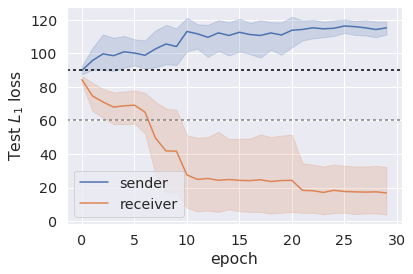

bias 15 run_id 74f6febddf62b63ac19f1c8b97024587 score 200.19224235534668 l1 15.043692736625669
len seed scores 25
config file ../results/gauss-deter-3/gauss-deter-3-bias15_74f6febddf62b63ac19f1c8b97024587/3/config.gin
num epochs 30
plotting from ../results/gauss-deter-3/gauss-deter-3-bias15_74f6febddf62b63ac19f1c8b97024587/3/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias15_74f6febddf62b63ac19f1c8b97024587/4/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias15_74f6febddf62b63ac19f1c8b97024587/2/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias15_74f6febddf62b63ac19f1c8b97024587/1/logs.json
plotting from ../results/gauss-deter-3/gauss-deter-3-bias15_74f6febddf62b63ac19f1c8b97024587/0/logs.json
here


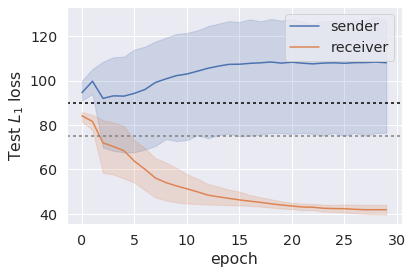

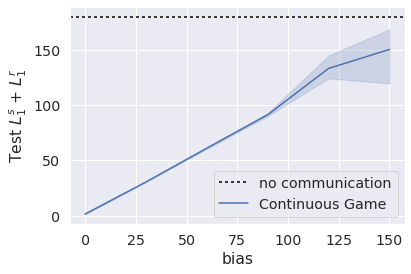

<Figure size 432x288 with 0 Axes>

In [154]:
## Gauss - Deter
resultspath = Path('../results/gauss-deter-3')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'Continuous Game', resultspath / 'plots')

bias 0 run_id 08b908aa12f1cfee2755f63a9f3642d1 score 0.023724289136006445 l1 0.11943168587982556
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/2/logs.json


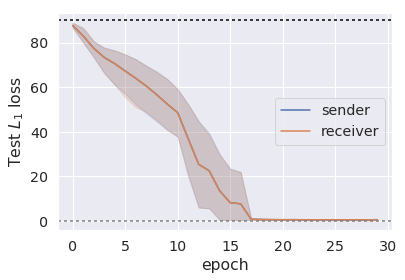

bias 3 run_id a39c2565ba81cedccddcdae737f74bc3 score 8.941015208372846 l1 3.0989989037066694
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/2/logs.json


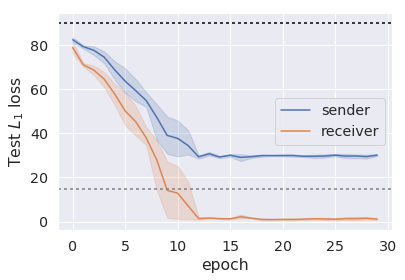

bias 6 run_id f8f3b2bea951b5513a9bd1c300dc532b score 35.94001171234529 l1 6.097282114215195
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/2/logs.json


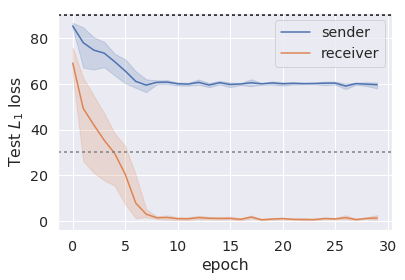

bias 9 run_id 29e46b17ed3d2774395a155418412a4c score 79.36047486394179 l1 9.082493419274687
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/2/logs.json


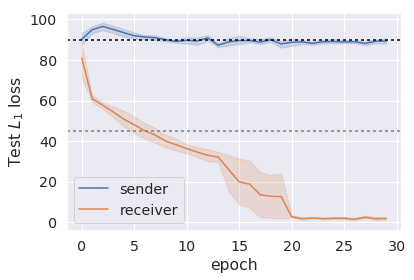

bias 12 run_id 1352d247ac1c3dfebe3928162a3fa621 score 159.93537233908663 l1 13.518980233669284
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/2/logs.json


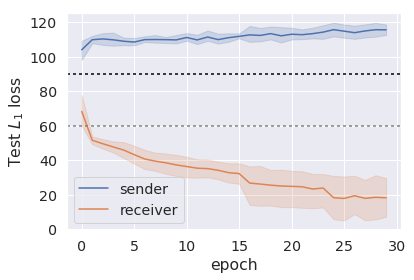

bias 15 run_id c998c8a2909d8559cbf176c0363b9ee8 score 211.85007728576664 l1 17.364742593765264
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/2/logs.json


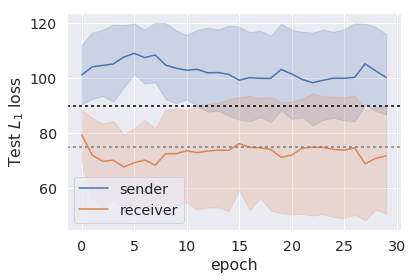

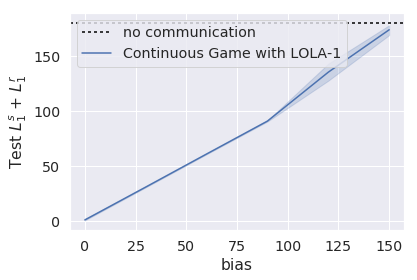

<Figure size 432x288 with 0 Axes>

In [429]:
## GaussLOLA1 - RecverLOLA1 -
resultspath = Path('../results/gausslola1-recverlola1')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'Continuous Game with LOLA-1', resultspath / 'plots')

In [97]:
logdir = '../results/cat-deter-50/cat-deter-50-bias0_7798811c75da80b54df57de258b5ec81/'

last_epochs = 30

logpath = Path(logdir)    

config_file = next(logpath.glob('**/*.gin'))
print(f'config file {config_file}')
gin.parse_config_file(config_file, skip_unknown=True)

bias = gin.config.query_parameter('Game.bias')
num_points = gin.config.query_parameter('Game.num_points')
num_epochs = gin.config.query_parameter('train.num_epochs')
print(f'num epochs {num_epochs}')
test_loss = CircleL1(num_points)

run_logs = []
for path in logpath.glob('**/*.json'):
    print(f'plotting from {path}')
    with open(path, 'r') as logfile:
        run_logs.append(pd.read_json(logfile))

logs = pd.concat(run_logs, ignore_index=True)
sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])

error_sum = pd.DataFrame(sender['test_l1_error'] + recver['test_l1_error']).join(logs['epoch'])
error_last = error_sum[error_sum['epoch'] >= num_epochs - last_epochs]
[error_last[i*last_epochs:(i+1)*last_epochs]['test_l1_error'].mean() for i in range(5)]
#     error_20 = error_sum[error_sum['epoch'] >= 20]
# return [error_20[i*last_epochs:i*last_epochs+rem_epochs]['test_l1_error'].mean() for i in range(5)]

config file ../results/cat-deter-50/cat-deter-50-bias0_7798811c75da80b54df57de258b5ec81/3/config.gin
num epochs 50
plotting from ../results/cat-deter-50/cat-deter-50-bias0_7798811c75da80b54df57de258b5ec81/3/logs.json
plotting from ../results/cat-deter-50/cat-deter-50-bias0_7798811c75da80b54df57de258b5ec81/4/logs.json
plotting from ../results/cat-deter-50/cat-deter-50-bias0_7798811c75da80b54df57de258b5ec81/2/logs.json
plotting from ../results/cat-deter-50/cat-deter-50-bias0_7798811c75da80b54df57de258b5ec81/1/logs.json
plotting from ../results/cat-deter-50/cat-deter-50-bias0_7798811c75da80b54df57de258b5ec81/0/logs.json


[2.0879763960838313,
 4.601901038487752,
 2.0893423080444333,
 1.9930120627085364,
 2.043553713957468]

In [96]:
[error_last[i*last_epochs:(i+1)*last_epochs]['test_l1_error'].mean() for i in range(5)]

[2.0879763960838313,
 4.601901038487752,
 2.0893423080444333,
 1.9930120627085364,
 2.043553713957468]

In [367]:
df[df['bias']==0]['l1']

0     0.229635
24    0.229635
6     0.229635
18    0.229635
12    0.229635
Name: l1, dtype: float64

In [346]:
df

,bias,error,seed_score,seed_scores,id,l1
0,0,0.841196,0.911078,0.911078,44dd5b063439037131e5651c432885ab,1.047117
24,0,0.841196,0.919574,17.362824,44dd5b063439037131e5651c432885ab,1.047117
6,0,0.841196,0.948956,9.324703,44dd5b063439037131e5651c432885ab,1.047117
18,0,0.841196,0.965904,14.274990,44dd5b063439037131e5651c432885ab,1.047117
12,0,0.841196,0.997428,13.447162,44dd5b063439037131e5651c432885ab,1.047117
1,3,62.083716,9.402009,0.919574,aaec48071fa2733d92c749ab06f14a0b,9.268642
25,3,62.083716,9.324703,17.808573,aaec48071fa2733d92c749ab06f14a0b,9.268642
7,3,62.083716,9.217501,9.217501,aaec48071fa2733d92c749ab06f14a0b,9.268642
19,3,62.083716,9.253856,14.726868,aaec48071fa2733d92c749ab06f14a0b,9.268642
13,3,62.083716,9.234165,13.308013,aaec48071fa2733d92c749ab06f14a0b,9.268642
